In [ ]:
pip install torch torchvision matplotlib


In [ ]:
pip install --upgrade certifi


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/adityaverma/Downloads/Leaf_detection'

# Create training and validation datasets
full_dataset = ImageFolder(root=data_dir, transform=data_transforms['train'])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Update transforms for validation dataset
val_dataset.dataset.transform = data_transforms['val']

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = full_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")


In [ ]:
import ssl
import urllib.request

ssl._create_default_https_context = ssl._create_unverified_context

# Now you can use urllib.request or any other library that fetches files over HTTPS

from torchvision import models
import torch.nn as nn

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Save the best model to a file
    torch.save(best_model_wts, 'leaf_model.pth')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)


val Accuracy: 98.7952%


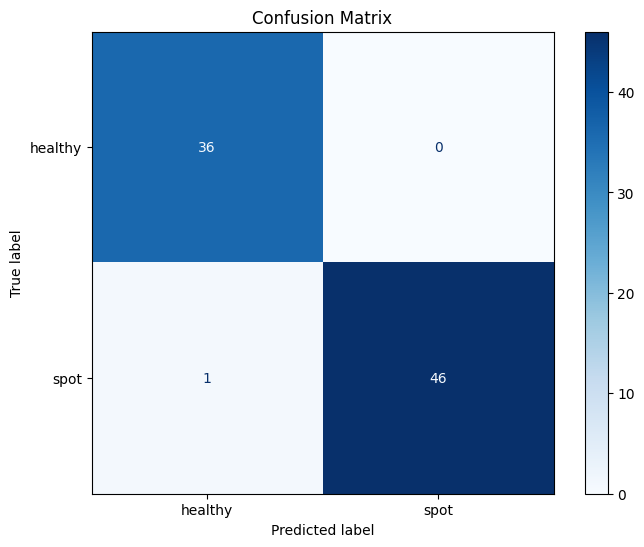

Showing 4 predictions:


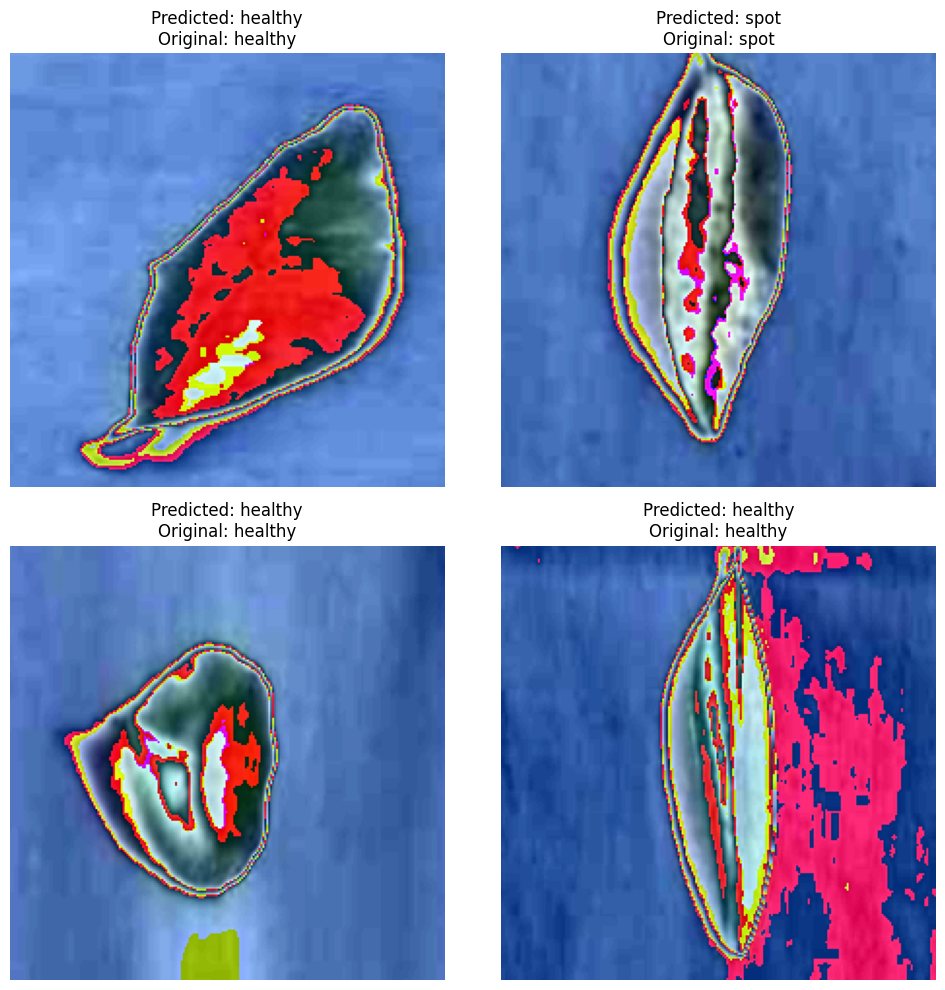

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.transforms as transforms

def evaluate_model(model, dataloaders, phase='val', num_predictions=4):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_predictions = []
    all_images = []

    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
            all_images.extend(inputs.cpu())

    accuracy = running_corrects.double() / dataset_sizes[phase]
    accuracy_percentage = accuracy * 100
    print(f'{phase} Accuracy: {accuracy_percentage:.4f}%')

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Show predictions for a few examples in a grid
    print(f'Showing {num_predictions} predictions:')
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < num_predictions:
                pred_class = class_names[all_predictions[index]]
                true_class = class_names[all_labels[index]]
                image = transforms.ToPILImage()(all_images[index])
                
                axes[i, j].imshow(image)
                axes[i, j].set_title(f'Predicted: {pred_class}\nOriginal: {true_class}')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    return accuracy

accuracy = evaluate_model(model_ft, dataloaders)
